In [ ]:
pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831124 sha256=4dbf8b9f268f80ec76e1e58e30c830125cb8e613c7f99348d049fce71b0fcd55
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [ ]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from tqdm import tqdm

# ------------------------------
# Wczytywanie danych wejściowych
# ------------------------------
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
metadata = pd.read_csv("item_metadata_filtered.csv")

# ------------------------------------------
# Mapowanie ID użytkowników i produktów na indeksy numeryczne wymagane przez LightFM
# ------------------------------------------
user_ids = train['user_id'].unique()
item_ids = train['item_id'].unique()
user_id_map = {uid: i for i, uid in enumerate(user_ids)}
item_id_map = {iid: i for i, iid in enumerate(item_ids)}
item_id_reverse_map = {i: iid for iid, i in item_id_map.items()}

train['user_idx'] = train['user_id'].map(user_id_map)
train['item_idx'] = train['item_id'].map(item_id_map)

# ------------------------------------------
# Przygotowanie cech produktów (item features)
# Uwzględnienie braków danych jako osobne cechy binarne
# ------------------------------------------
metadata['main_category'] = metadata['main_category'].fillna("Unknown")
metadata['category'] = metadata['category'].fillna("Unknown")
metadata['store_missing'] = metadata['store'].isnull()
metadata['store'] = metadata['store'].fillna("Unknown")
metadata['price_available'] = metadata['price'].notnull()
metadata['description_available'] = metadata['description'].apply(lambda x: bool(x and len(x.strip()) > 0))
metadata['price_missing'] = metadata['price'].isnull()
metadata['price_filled'] = metadata['price'].fillna(-1)
metadata['price_bin'] = pd.qcut(metadata.loc[~metadata['price_missing'], 'price'], q=5, labels=False, duplicates='drop')
metadata['rating_bin'] = pd.cut(metadata['average_rating'], bins=[0, 2, 3, 4, 5], labels=False)
metadata['rating_number_missing'] = metadata['rating_number'].isnull()
metadata['rating_number_filled'] = metadata['rating_number'].fillna(-1)
metadata['rating_number_log_bin'] = pd.cut(np.log1p(metadata.loc[~metadata['rating_number_missing'], 'rating_number']), bins=5, labels=False)
metadata['item_idx'] = metadata['parent_asin'].map(item_id_map)
metadata = metadata[metadata['item_idx'].notnull()]
metadata['item_idx'] = metadata['item_idx'].astype(int)

# Lista wszystkich możliwych cech, które model może uwzględniać
item_features_list = (
    ['category:' + cat for cat in metadata['main_category'].unique()] +
    ['subcategory:' + cat for cat in metadata['category'].unique()] +
    ['store:' + store for store in metadata['store'].unique()] +
    ['has_images', 'price_available', 'description_available', 'price_missing', 'rating_number_missing', 'store_missing'] +
    ['price_bin:' + str(i) for i in range(5)] +
    ['rating_bin:' + str(i) for i in range(4)] +
    ['rating_number_log_bin:' + str(i) for i in range(5)]
)

# Budowanie obiektu dataset dla LightFM
dataset = Dataset()
dataset.fit(users=user_ids, items=item_ids)
dataset.fit_partial(items=item_ids, item_features=item_features_list)

# Budowa macierzy interakcji użytkowników z produktami
(interactions, _) = dataset.build_interactions(
    [(row['user_id'], row['item_id'], row['rating']) for _, row in train.iterrows()]
)

# Funkcja generująca cechy produktów uwzględniająca brakujące dane
def build_item_features(metadata):
    features = []
    for _, row in metadata.iterrows():
        feats = [
            'category:' + row['main_category'],
            'subcategory:' + row['category'],
            'store:' + row['store']
        ]
        if row['store_missing']:
            feats.append('store_missing')
        if row['has_images']:
            feats.append('has_images')
        if row['price_available']:
            feats.append('price_available')
        if row['description_available']:
            feats.append('description_available')
        if row['price_missing']:
            feats.append('price_missing')
        else:
            feats.append(f'price_bin:{int(row["price_bin"])}')
        feats.append(f'rating_bin:{int(row["rating_bin"])}')
        if row['rating_number_missing']:
            feats.append('rating_number_missing')
        else:
            feats.append(f'rating_number_log_bin:{int(row["rating_number_log_bin"])}')
        features.append((row['parent_asin'], feats))
    return features

# Budowanie cech produktów dla modelu
item_features = dataset.build_item_features(build_item_features(metadata))

# ------------------------------------------
# Trening modelu rekomendacyjnego LightFM
# loss='warp' optymalizuje ranking (lepszy niż klasyczny bpr dla rankingów)
# no_components = 256 definiuje wymiarowość ukrytej przestrzeni cech
# ------------------------------------------
model = LightFM(loss='warp', no_components=256)
model.fit(interactions, item_features=item_features, epochs=50, num_threads=8)

# ------------------------------------------
# Predykcja na zbiorze testowym
# Użytkownicy spoza treningu dostają fallback z popularnych produktów
# Produkty już obejrzane przez użytkownika są pomijane
# ------------------------------------------
top_popular_items = train['item_id'].value_counts().index.tolist()
user_seen_items = train.groupby('user_idx')['item_idx'].apply(set).to_dict()
all_item_indices = np.arange(len(item_id_map))

submission = []
top_popular_item_str = ' '.join(map(str, top_popular_items[:10]))

for uid in tqdm(test['user_id'].values):
    if uid not in user_id_map:
        submission.append((uid, top_popular_item_str))
        continue

    uidx = user_id_map[uid]
    seen = user_seen_items.get(uidx, set())
    user_ids_array = np.repeat(uidx, len(all_item_indices))

    scores = model.predict(user_ids_array, all_item_indices, item_features=item_features)
    top_idxs = [i for i in np.argsort(-scores) if i not in seen][:10]
    top_items = [item_id_reverse_map[i] for i in top_idxs]

    submission.append((uid, ' '.join(map(str, top_items))))

# Zapis predykcji do pliku zgodnego z wymaganiami konkursu Kaggle
submission_df = pd.DataFrame(submission, columns=['user_id', 'predictions'])
submission_df.to_csv("submission_kaggle.csv", index=False)

from google.colab import files
files.download('submission_kaggle.csv')

100%|██████████| 412461/412461 [10:42:38<00:00, 10.70it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   user_id                                        predictions
0        0  20832 13451 11315 18550 12595 19334 6864 12104...
1        1  20832 27832 10719 36507 28271 31656 21109 2473...
2        3  32523 20832 32475 24931 32535 16504 28162 1259...
3        5  40802 30229 13902 21038 30691 72390 6859 13900...
4        6  12595 41330 57772 24931 32523 12895 38657 6090...


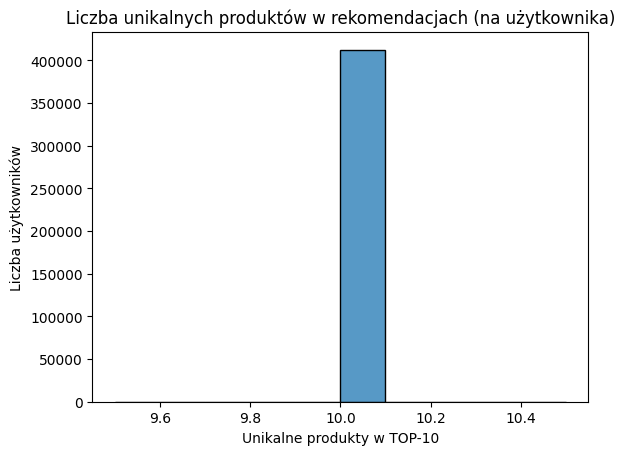

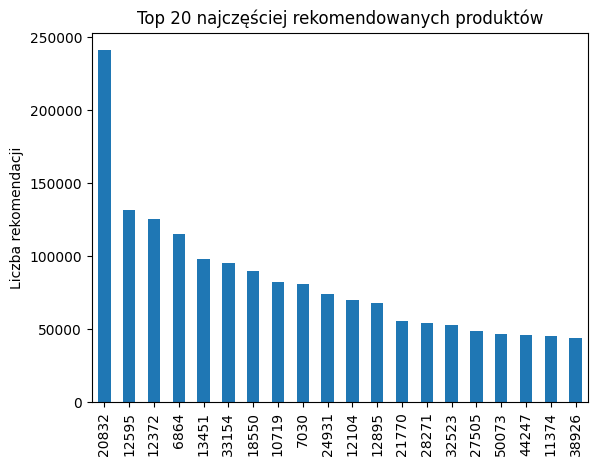


Liczba unikalnych produktów w predykcjach: 8675


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
submission = pd.read_csv("submission_kaggle.csv", sep=",", header=0)
print(submission.head())
submission['predicted_list'] = submission['predictions'].str.split()
submission['unique_count'] = submission['predicted_list'].apply(lambda x: len(set(x)))

plt.figure()
sns.histplot(submission['unique_count'], bins=10, kde=False)
plt.title("Liczba unikalnych produktów w rekomendacjach (na użytkownika)")
plt.xlabel("Unikalne produkty w TOP-10")
plt.ylabel("Liczba użytkowników")
plt.show()

# Statystyka: najczęściej rekomendowane produkty
top_recommended = pd.Series(np.concatenate(submission['predicted_list'].values)).value_counts().head(20)
plt.figure()
top_recommended.plot(kind='bar')
plt.title("Top 20 najczęściej rekomendowanych produktów")
plt.ylabel("Liczba rekomendacji")
plt.show()

print("\nLiczba unikalnych produktów w predykcjach:", submission['predicted_list'].explode().nunique())